In [2]:
import torch
import torchvision
from torch.optim.sgd import SGD
import kornia
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pyiqa
from losses import init_structure_loss

def imshow(input: torch.Tensor):
    out = torchvision.utils.make_grid(input, nrow=2, padding=5)
    out_np: np.ndarray = kornia.utils.tensor_to_image(out.to(device='cpu'))
    min_val = np.min(out_np)
    max_val = np.max(out_np)
    # Normalize the image to range [0, 1]
    normalized_np = (out_np - min_val) / (max_val - min_val)
    plt.imshow(normalized_np)
    plt.axis("off")
    plt.show()

def image_refine(ref, edit, loss_fn, iteration, weight=1.0):
    edit_copy = edit.clone()
    edit_copy.requires_grad = True
    optimizer = SGD(params=[edit_copy], lr=1e-1, momentum=0.5)

    for i in range(iteration):
        optimizer.zero_grad()
        loss = weight * loss_fn(ref, edit_copy)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f'{i} iter loss : {loss}')
    
    return edit_copy

/usr/local/envs/main/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def sobel_L1(ref, edit):
    ref_edge = kornia.filters.sobel(ref)
    edit_edge = kornia.filters.sobel(edit)
    loss_fn = torch.nn.MSELoss()
    loss = loss_fn(ref_edge, edit_edge)
    return loss

def DexiNed_L1(ref, edit):
    net = kornia.filters.DexiNed(pretrained=False)
    ref_edge = net(ref)
    edit_edge = net(edit)
    loss_fn = torch.nn.MSELoss()
    loss = loss_fn(ref_edge, edit_edge)
    return loss

def canny_L1(ref, edit):
    ref_edge, _ = kornia.filters.canny(ref)
    edit_edge, _ = kornia.filters.canny(edit)
    loss_fn = torch.nn.MSELoss()
    loss = loss_fn(ref_edge, edit_edge)
    return loss

class SSIM_Structure:
    def __init__(self, as_loss=True, **kwargs):
        if 'get_ssim_map' in kwargs:
            self.get_ssim_map = kwargs['get_ssim_map']
        self.l = pyiqa.create_metric('ssim_structure', device='cuda', as_loss=as_loss, **kwargs)
    
    def __call__(self, source, target):
        if hasattr(self, 'get_ssim_map') and self.get_ssim_map is True:
            ssim_val, ssim_map = self.l(source, target)
            self.ssim_map = ssim_map
            return 1. - ssim_val
        return 1. - self.l(source, target)

class G_SSIM_Structure:
    def __init__(self, as_loss=True, **kwargs):
        if 'get_ssim_map' in kwargs:
            self.get_ssim_map = kwargs['get_ssim_map']
        self.l = pyiqa.create_metric('ssim_structure', device='cuda', as_loss=as_loss, **kwargs)
    
    def __call__(self, source, target):
        source_edge = kornia.filters.sobel(source)
        target_edge = kornia.filters.sobel(target)
        if hasattr(self, 'get_ssim_map') and self.get_ssim_map is True:
            ssim_val, ssim_map = self.l(source_edge, target_edge)
            self.ssim_map = ssim_map
            return 1. - ssim_val
        return 1. - self.l(source_edge, target_edge)

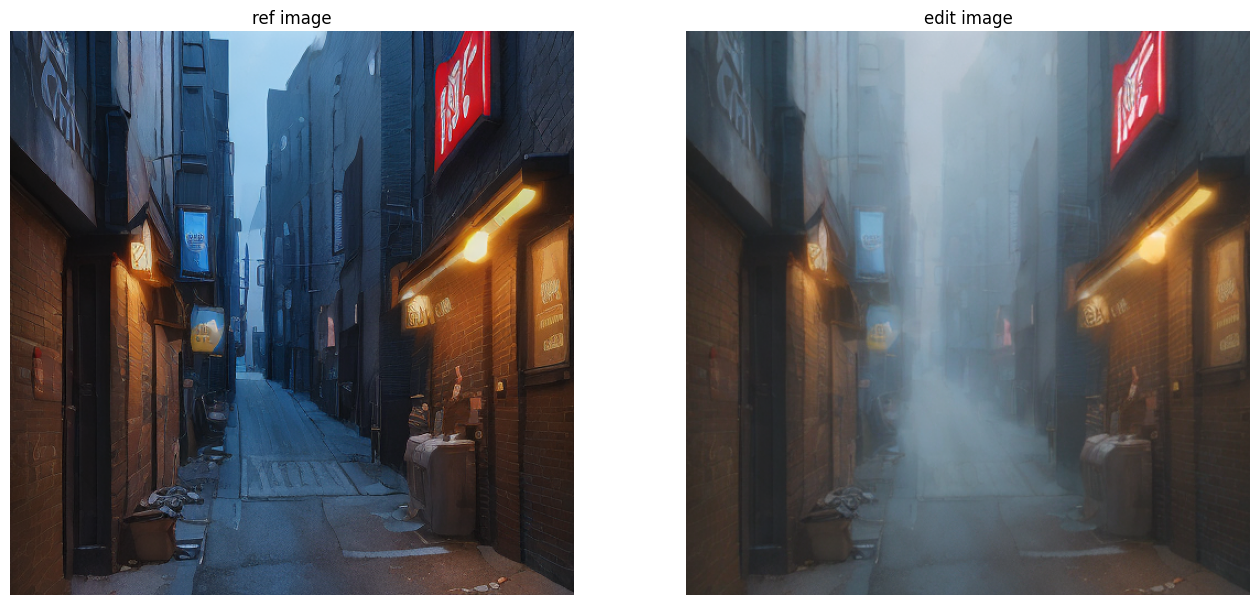

In [4]:
ref_tensor = kornia.io.load_image("images/back alley with signs in New York, night.png", kornia.io.ImageLoadType.RGB32, device='cuda')[None, ...]  # BxCxHxW
ref_array = kornia.tensor_to_image(ref_tensor.to(device='cpu'))
edit_tensor = kornia.io.load_image("images/back alley with signs in New York, night_foggy scene.png", kornia.io.ImageLoadType.RGB32, device='cuda')[None, ...]  # BxCxHxW
edit_array = kornia.tensor_to_image(edit_tensor.to(device='cpu'))

fig, axs = plt.subplots(1, 2, figsize=(16, 16))
axs = axs.ravel()

axs[0].axis("off")
axs[0].set_title("ref image")
axs[0].imshow(ref_array)

axs[1].axis("off")
axs[1].set_title("edit image")
axs[1].imshow(edit_array)

plt.show()

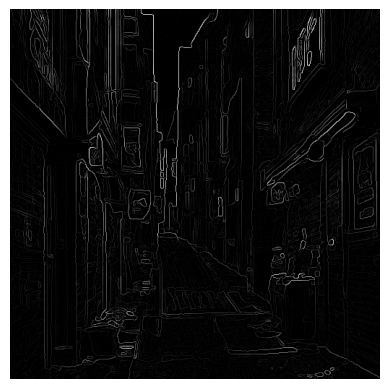

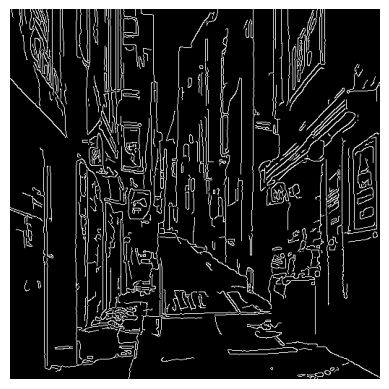

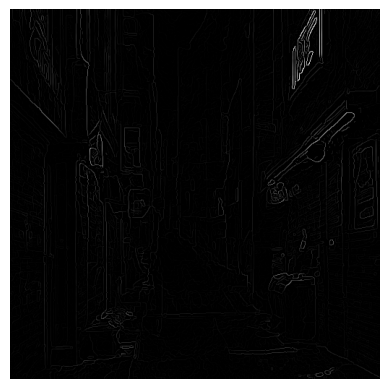

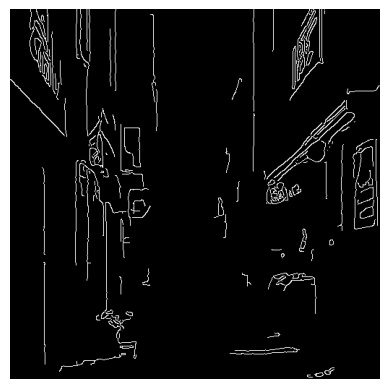

In [5]:
ref_canny_mag, ref_canny_edge = kornia.filters.canny(ref_tensor)
edit_canny_mag, edit_canny_edge = kornia.filters.canny(edit_tensor)
imshow(ref_canny_mag)
imshow(ref_canny_edge)
imshow(edit_canny_mag)
imshow(edit_canny_edge)

0 iter loss : 13.551727294921875
100 iter loss : 8.37292766571045
200 iter loss : 5.604159832000732
300 iter loss : 4.060250759124756
400 iter loss : 3.207512140274048
500 iter loss : 2.7111270427703857
600 iter loss : 2.3787357807159424
700 iter loss : 2.1517715454101562
800 iter loss : 1.9493136405944824
900 iter loss : 1.801038146018982


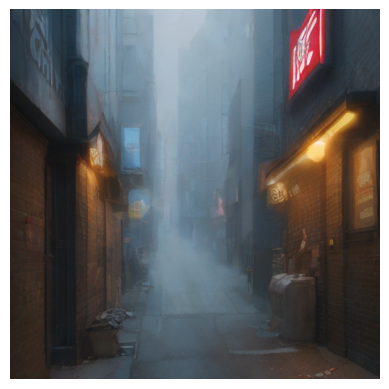

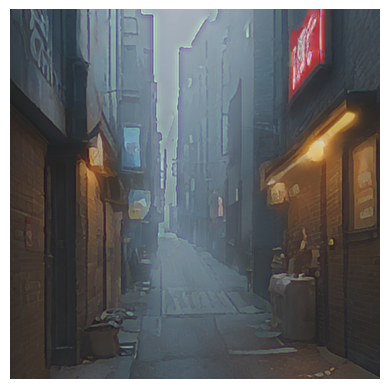

In [6]:
edit_refine = image_refine(ref_tensor, edit_tensor, canny_L1, 1000, 1000)
imshow(edit_tensor)
imshow(edit_refine)

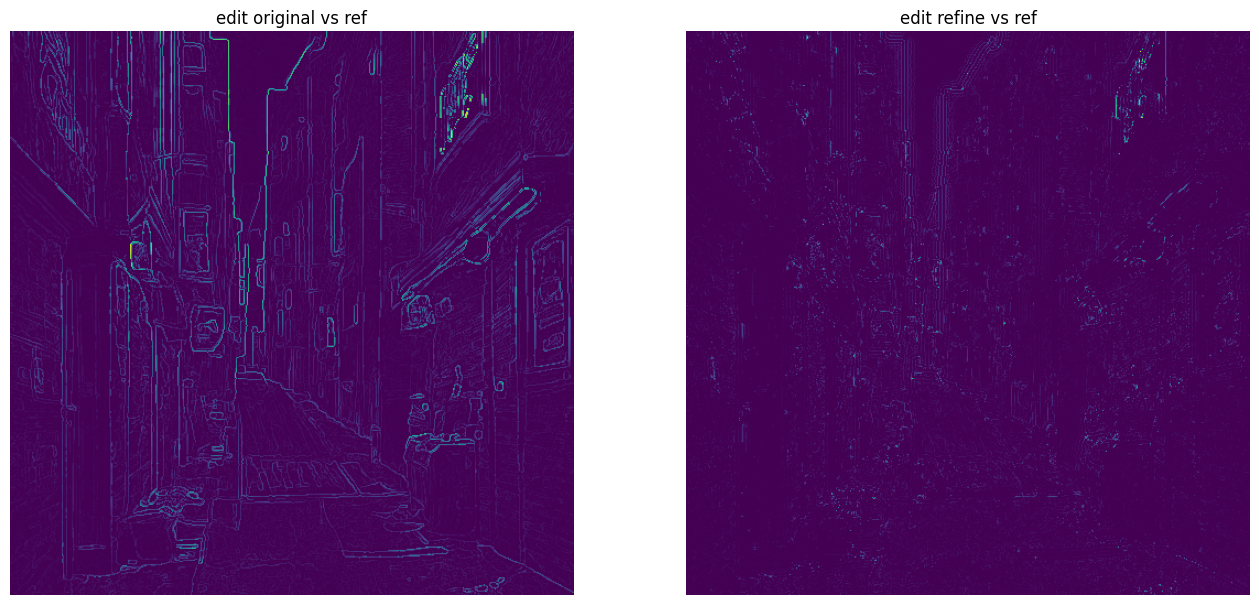

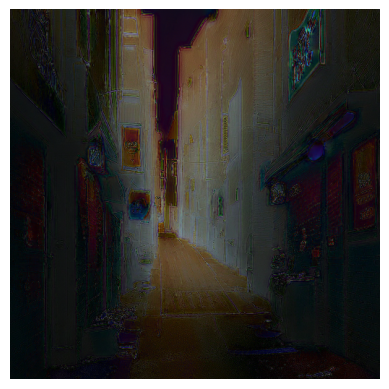

In [7]:
edit_refine_canny_mag, edit_refine_canny_edge = kornia.filters.canny(edit_refine)

fig, axs = plt.subplots(1, 2, figsize=(16, 16))
axs = axs.ravel()

axs[0].axis("off")
axs[0].set_title("edit original vs ref")
axs[0].imshow(kornia.utils.tensor_to_image(torch.abs(edit_canny_mag - ref_canny_mag).to(device='cpu')))

axs[1].axis("off")
axs[1].set_title("edit refine vs ref")
axs[1].imshow(kornia.utils.tensor_to_image(torch.abs(edit_refine_canny_mag - ref_canny_mag).to(device='cpu')))

plt.show()


imshow(torch.abs(edit_refine - ref_tensor))

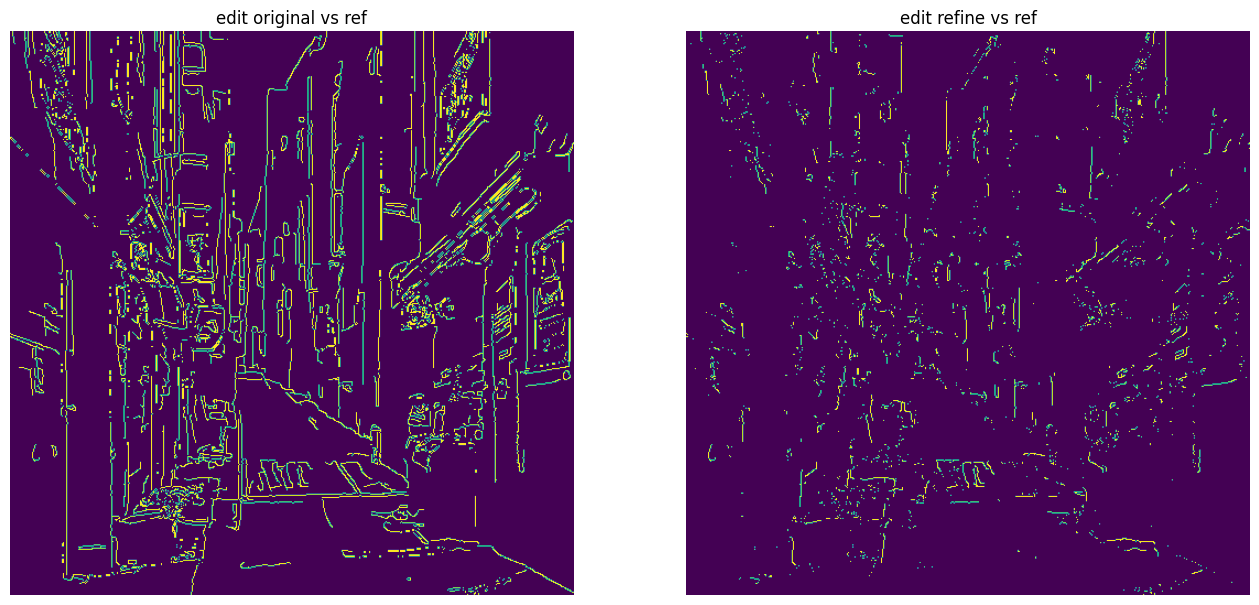

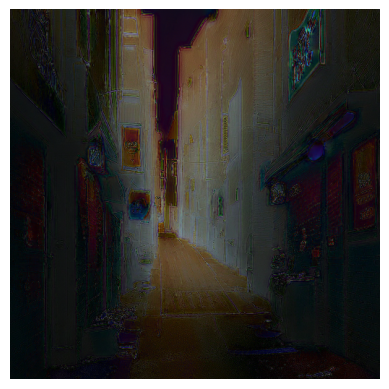

In [8]:
edit_refine_canny_mag, edit_refine_canny_edge = kornia.filters.canny(edit_refine)

fig, axs = plt.subplots(1, 2, figsize=(16, 16))
axs = axs.ravel()

axs[0].axis("off")
axs[0].set_title("edit original vs ref")
axs[0].imshow(kornia.utils.tensor_to_image(torch.abs(edit_canny_edge - ref_canny_edge).to(device='cpu')))

axs[1].axis("off")
axs[1].set_title("edit refine vs ref")
axs[1].imshow(kornia.utils.tensor_to_image(torch.abs(edit_refine_canny_edge - ref_canny_edge).to(device='cpu')))

plt.show()


imshow(torch.abs(edit_refine - ref_tensor))